In [2]:
class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        self.model = model # 模型
        self.optimizer = optimizer # 优化器
        self.loss_fn = loss_fn # 损失函数
        self.metric = metric # 评估指标

    # 模型训练
    def train(self, train_dataset,dev_dataset=None, **kwargs):
        pass

    # 模型评价
    def evaluate(self, data_set, **kwargs):
        pass

    # 模型保存
    def save_model(self, save_path):
        pass

    # 模型加载
    def load_model(self, model_path):
        pass

In [3]:
import pandas as pd

data = pd.read_csv("./boston_house_prices.csv")
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
#通过isna()方法判断数据中各元素是否缺失，然后通过sum()方法统计每个字段缺失情况
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

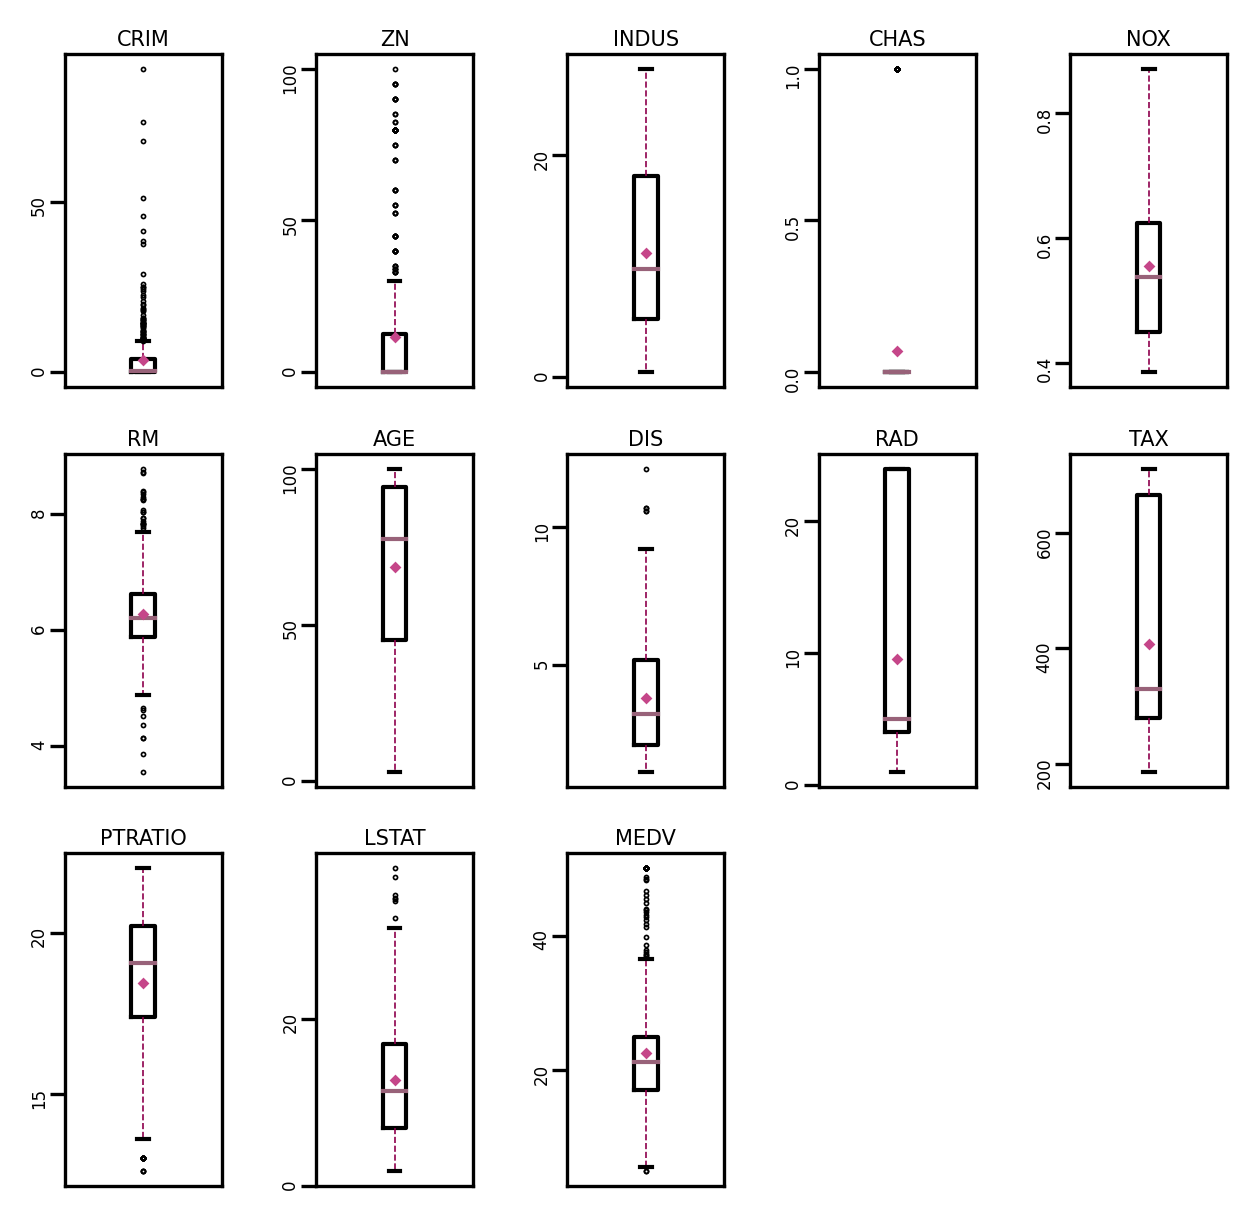

In [8]:
import matplotlib.pyplot as plt #可视化工具

# 箱线图查看异常值
def boxplot(data,fig_name):
    # 绘制每个属性的箱线图
    data_col = list(data.columns)

    # 连续画几个图片
    plt.figure(figsize=(5,5),dpi=300)
    # 子图调整
    plt.subplots_adjust(wspace=0.6)
    for i, col_name in enumerate(data_col):
        plt.subplot(3,5,i+1)
        #画箱线图
        plt.boxplot(data[col_name],
                    showmeans=True,
                    meanprops={"markersize":1,"marker":"D","markeredgecolor":"#C54689"}, #均值的属性
                    medianprops={"color":"#986279"}, # 中位数线的属性
                    whiskerprops={"color":"#8E004D", "linewidth":0.4, 'linestyle':"--"},
                    flierprops={"markersize":0.4},
                    )
        #图名
        plt.title(col_name,fontdict={"size":5},pad=2)
        # y方向刻度
        plt.yticks(fontsize=4, rotation=90)
        plt.tick_params(pad=0.5)
        # x方向刻度
        plt.xticks([])

    plt.savefig(fig_name)
    plt.show()

boxplot(data, 'ml-vis5.pdf')
        

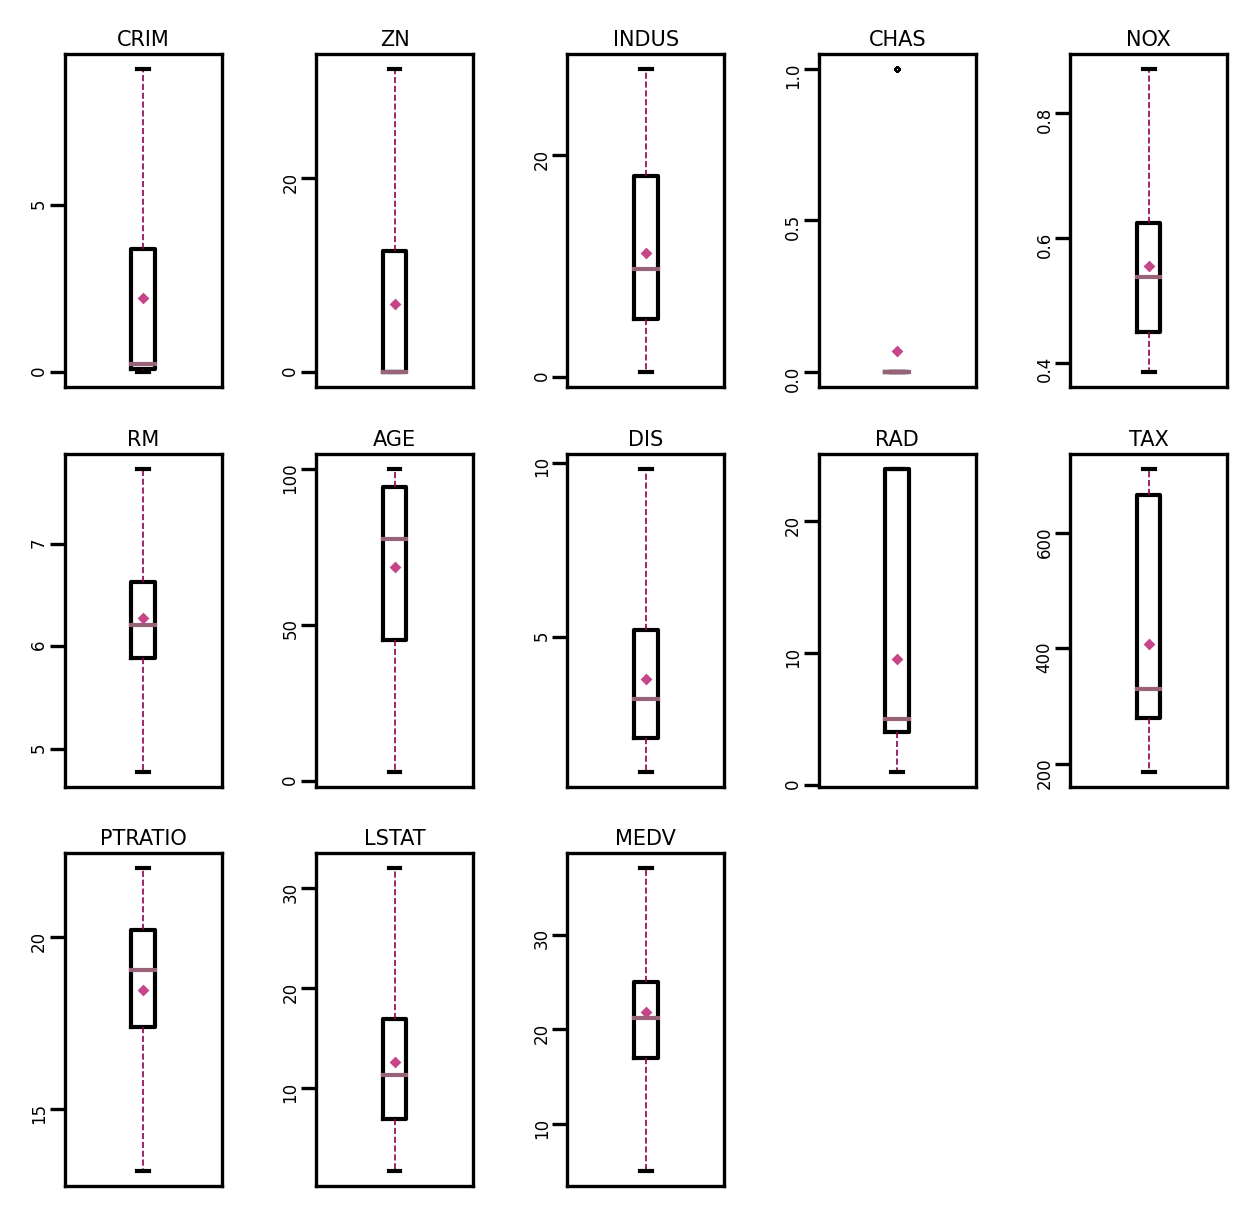

In [13]:
# 四分位处理异常值
# 使用四分位值筛选出箱线图中分布的异常值，并将这些数据视为噪声，其将被临界值取代
num_features = data.select_dtypes(exclude=['object','bool']).columns.tolist()

for feature in num_features:
    if feature == 'CHAS':
        continue

    Q1 = data[feature].quantile(q=0.25)# 下四分位
    Q3 = data[feature].quantile(q=0.75) # 上四分位

    IQR = Q3-Q1
    top = Q3+1.5*IQR # 最大估计值
    bot = Q1-1.5*IQR # 最小估计值
    values = data[feature].values
    values[values > top] = top # 临界值取代噪声
    values[values < bot] = bot # 临界值取代噪声
    data[feature] = values.astype(data[feature].dtypes)

# 再次查看箱线图，异常值已被临界值替换（数据量较多或本身异常值较少时，箱线图展示会不容易体现出来）
boxplot(data,'ml-vis6.pdf')

In [18]:
# 数据集划分

import paddle

paddle.seed(10)

# 划分训练集和数据集

def train_test_split(X,y,train_percent=0.8):
    n = len(X)
    shuffled_indices = paddle.randperm(n) # 返回一个数值在0到n-1、随机排列的1-D Tensor
    train_set_size = int(n*train_percent)
    train_indices = shuffled_indices[:train_set_size]
    test_indices = shuffled_indices[train_set_size:]

    X = X.values
    y = y.values
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

X = data.drop(['MEDV'],axis=1)
y = data['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X,y) # X_train每一行是个样本，shape[N,D]

In [19]:
# 特征归一化

import paddle

X_train = paddle.to_tensor(X_train,dtype="float32")
X_test = paddle.to_tensor(X_test,dtype="float32")
y_train = paddle.to_tensor(y_train,dtype="float32")
y_test = paddle.to_tensor(y_test,dtype="float32")

X_min = paddle.min(X_train,axis=0)
X_max = paddle.max(X_train,axis=0)

X_train = (X_train-X_min)/(X_max-X_min)
X_test = (X_test-X_min)/(X_max-X_min)

# 训练集构造
train_dataset = (X_train,y_train)
# 测试集构造
test_dataset = (X_test,y_test)

In [20]:
# 模型构建
from op import Linear

# 模型实例化
input_size =12
model = Linear(input_size)

In [21]:
# 在测试集上使用MSE对模型性能进行评估。本案例利用飞桨框架提供的MSELoss API实现
import paddle.nn as nn
mse_loss = nn.MSELoss()

In [22]:
# 完善Runner类
import paddle
import os
from opitimizer import optimizer_lsm

class Runner(object):
    def __init__(self,model,optimizer,loss_fn, metric):
        # 优化器和损失函数为None,不再关注

        # 模型
        self.model = model
        # 评估指标
        self.metric = metric
        # 优化器
        self.optimizer = optimizer
        
    def train(self,dataset,reg_lambda,model_dir):
        X,y = dataset
        self.optimizer(self.model, X, y, reg_lambda)

        # 保存模型
        self.save_model(model_dir)

    def evaluate(self,dataset, **kwargs):
        X,y = dataset
        y_pred = self.model(X)
        result = self.metric(y_pred,y)

        return result
    
    def predict(self, X, **kwargs):
        return self.model(X)
    
    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        params_saved_path = os.path.join(model_dir,'params.pdtensor')
        paddle.save(model.params,params_saved_path)

    def load_model(self, model_dir):
        params_saved_path = os.path.join(model_dir,'params.pdtensor')
        self.model.params = paddle.load(params_saved_path)

optimizer = optimizer_lsm

# 实例化 Runner 
runner = Runner(model, optimizer=optimizer,loss_fn=None,metric=mse_loss)

In [23]:
# 模型训练
save_dir = './models'

# 启动训练
runner.train(train_dataset,reg_lambda=0,model_dir=save_dir)

In [24]:
columns_list = data.columns.to_list()
weights = runner.model.params['w'].tolist()
b = runner.model.params['b'].item()

for i in range(len(weights)):
    print(columns_list[i],"weight:",weights[i])

print("b:",b)

CRIM weight: -5.705706596374512
ZN weight: 1.1804513931274414
INDUS weight: -0.9549165964126587
CHAS weight: 1.9173963069915771
NOX weight: -5.872139930725098
RM weight: 9.139512062072754
AGE weight: -0.6965270042419434
DIS weight: -9.78866958618164
RAD weight: 7.860574245452881
TAX weight: -5.23676872253418
PTRATIO weight: -6.668815612792969
LSTAT weight: -14.417861938476562
b: 32.554229736328125


In [27]:
#加载模型权重
runner.load_model(save_dir)

mse = runner.evaluate(test_dataset)
print('MSE:',mse.item())

MSE: 17.047893524169922


In [31]:
runner.load_model(save_dir)

pred = runner.predict(X_test[:1]).item()
print("真实房价：",y_test[:1].item())
print("预测房价：",pred)

真实房价： 21.399999618530273
预测房价： 24.058433532714844
